In [2]:
# Import of basic libraries/packages.

import pandas as pd
import os
import numpy as np
import dask.dataframe as dd 
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
# File with variables of interest: last version: 21/02.  

# df_cct = pd.read_parquet("/Users/vanheuverswyn/Desktop/ProjetStatapp/df_all.parquet")

In [3]:
# Creation of 2000 parquet (1 per user). 

#for k in range (2000):
    #df=df_cct[df_cct['User']==k]
    #df.to_parquet('/Users/vanheuverswyn/Desktop/ProjetStatapp/parquet_all/df_all'+ str(k)+'.parquet')

In [4]:
from sklearn import preprocessing
# Function that removes unnecessary columns, creates the 'Number_year_since_PIN_last_Changed' column, 
# that creates dummies from category variables and normalizes non-category variables. 

def modification_data_frame(df_cct):
    
    # Remove columns that are no longer useful. 
    df_cct =  df_cct.drop([  'day_of_week','Card', 'Month', 'Day', 'Hours'], axis = 1)
    
    # To avoid problems when concatenating dataframes (df_cct and dummies), we reset the indexes
    df_cct=df_cct.reset_index()    
    df_cct =  df_cct.drop(["index"], axis = 1)

    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    features_array = enc.fit_transform(df_cct[['Card Brand']]).toarray()
    features_labels = np.hstack(np.array(enc.categories_))
    df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels).reset_index()], axis = 1)

    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    features_array = enc.fit_transform(df_cct[['Use Chip']]).toarray()
    features_labels = np.hstack(np.array(enc.categories_))
    df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels).reset_index()], axis = 1)

    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    features_array = enc.fit_transform(df_cct[['Card Type']]).toarray()
    features_labels = np.hstack(np.array(enc.categories_))
    df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

    df_cct =  df_cct.drop(["index","Card Brand",'Card Type'], axis = 1)
    
    # We centre and reduce the following columns to be normalised:
    Normalizing_List=['Amount', 'Credit Limit', 'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'daily_amount', 'nb_daily_declines_card',
       'nb_weekly_declines_card', 'nb_monthly_declines_card',
       'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt',
       'year_diff']
    df_cct_not_normalized=df_cct.copy()
    for i in Normalizing_List:
        if np.std(df_cct[i])!=0:
            df_cct[i] = (df_cct[i]-np.mean(df_cct[i]))/np.std(df_cct[i])
        else:
            df_cct[i] = (df_cct[i]-np.mean(df_cct[i])) 
    return df_cct

In [4]:
# Application of the function to the 2000 parquet -> you get the modified 
# parquets and the parquets with the associated frauds for each user in one file. 
    
for k in range (2000):
    df=pd.read_parquet("/Users/vanheuverswyn/Desktop/ProjetStatapp/parquet_all/df_all"+str(k)+".parquet")
    
    df_modified=modification_data_frame(df)
    IsFraud=df_modified["Is Fraud?"].to_frame()
    df_modified=df_modified.drop(["Is Fraud?"],axis = 1)
    
    df_modified.to_parquet('/Users/vanheuverswyn/Desktop/ProjetStatapp/parquet_modified_all/df_all'+ str(k)+'.parquet')
    IsFraud.to_parquet('/Users/vanheuverswyn/Desktop/ProjetStatapp/parquet_modified_all/IsFraud'+ str(k)+'.parquet')

In [9]:
# Function that applies DBSCAN to the dataFrame. 

def dbScann (df_cct):
    X = df_cct.values
    X.astype(np.float64)
    #eps min_sample et n_jobs a déterminer  (fixer le meme pour tous ou automatiser une selection?)
    clustering=cluster.DBSCAN(eps=0.8, min_samples=5, n_jobs = -1)
    clustering.fit(X)
    
def PCA(df_cct):    
    pca = PCA()
    pca.fit(df_cct)
    df_cct.columns = df_cct.columns.astype("str")
    df_cct_pca = pca.transform(df_cct)
    df_cct_pca_df = pd.DataFrame({
    "Dim1" : df_cct_pca[:,0], 
    "Dim2" : df_cct_pca[:,1]})
    df_cct_pca_df["labels"] = clustering.labels_

In [11]:
# Let's start with the first 200 Users: 

f = os.listdir("/home/onyxia/work/Datasets")
f = [v for v in f if "df_all" in v][:2000]
df_cct1 = [pd.read_parquet("/home/onyxia/work/Datasets/" + v) for v in f] # Creating a dataframe list.

In [13]:
# We have already removed the categorical variables: we also remove User: 
df_cct = [df_cct1[i].drop("User",  axis = "columns") for i in range(len(df_cct1))]

In [119]:
# Function to remove categorical variables:

def reshapedf(df):
    unique_values = {v : df[v].unique() for v in df.columns}
    unique_values = {v : unique_values[v] for v in unique_values.keys() if len(unique_values[v]) <= 2}
    if "Credit Limit" in list(unique_values.keys()) : 
        del unique_values['Credit Limit']
    return df.drop(list(unique_values.keys()), axis = "columns")

In [15]:
# Function to implement DBSCAN on a dataset and return the number of clusters:

from sklearn import cluster 
from collections import Counter

def DBSCAN1(df_cct, eps, min_sample):
    X = df_cct.values
    X.astype(np.float64)
    # eps min_sample and n_jobs to determine.   
    clustering=cluster.DBSCAN(eps = eps, min_samples = min_sample, n_jobs = -1)
    clustering.fit(X)
    return Counter(clustering.labels_)

In [16]:
# DBSCAN + insert the label into a new variable for each transaction.

def DBSCAN2(df, eps, min_sample):
    X = df.values
    X.astype(np.float64)
    clustering=cluster.DBSCAN(eps = eps, min_samples = min_sample, n_jobs = -1)
    clustering.fit(X)
    df.insert(1,"label", clustering.labels_)
    return df   jnj

In [17]:
# Functions to calculate the average distance between points: find eps: 

def Euclid_distance(point1, point2):
    return np.linalg.norm(point1 - point2)
    
def Transac_distance(point1, set2):
    return np.mean([Euclid_distance(point1, point2) for point2 in set2])

def User_distance(User):
    return np.mean([Transac_distance(point1, User) for point1 in User])


In [18]:
# Choose eps: 
#User_distance(df_cct[0].values) # 4.069 idea to try, then go by hand. 

In [387]:
# Test : find min_sample : idea : 0.002*df.shape[0]: 
# look at the number of clusters and number of transactions in each cluster: 
[DBSCAN1(df, 2.5, max(2,round(0.002*df.shape[0]))) for df in df_cct[:20]]
# 2.5 seems okay for eps: look at number of clusters and transactions per cluster. 

[Counter({-1: 418, 0: 15042, 1: 272}),
 Counter({0: 47, -1: 7, 1: 2}),
 Counter({0: 19004, -1: 556, 1: 355}),
 Counter({0: 7306, -1: 265, 1: 174}),
 Counter({-1: 390, 0: 204, 1: 9715, 2: 28}),
 Counter({-1: 9, 0: 112}),
 Counter({0: 11, -1: 7, 1: 2, 2: 34, 3: 3}),
 Counter({-1: 48, 0: 1729, 1: 11, 2: 150, 3: 7, 4: 24, 5: 10}),
 Counter({0: 24966, -1: 622, 1: 554}),
 Counter({0: 2929, -1: 84, 1: 77, 2: 5, 3: 76}),
 Counter({0: 269, -1: 49, 1: 5, 2: 8, 3: 5, 4: 1413, 5: 17}),
 Counter({0: 9728, 1: 302, -1: 331, 2: 24}),
 Counter({-1: 507, 0: 21974, 1: 427}),
 Counter({0: 12863, -1: 292, 1: 423, 2: 1509}),
 Counter({0: 4449,
          1: 59,
          2: 204,
          -1: 212,
          3: 32,
          6: 23,
          4: 1007,
          5: 23,
          7: 18}),
 Counter({0: 41, -1: 236, 1: 10774, 2: 264}),
 Counter({0: 9140, -1: 248, 2: 227, 1: 603}),
 Counter({0: 16171, 1: 428, 3: 40, -1: 476, 2: 65}),
 Counter({0: 100, 1: 2, -1: 12, 2: 2, 3: 5, 4: 13, 5: 2, 6: 2}),
 Counter({-1: 197

In [19]:
# The cluster number is assigned to each transaction:
df_cct_clustered = [DBSCAN2(df,2.5, max(2,round(0.002*df.shape[0]))) for df in df_cct]

In [20]:
# We gather the transactions by cluster/label: and take the average: 
df_cct_clustered1 = [df.groupby("label").mean().reset_index() for df in df_cct_clustered]

In [50]:
# We put it all together and do DBSCAN on the subgroups created:
df_final = pd.concat(df_cct_clustered1).reset_index(drop = True).drop("label", axis = "columns")

In [51]:
DBSCAN1(df_final,1.25,max(2,round(0.002*df_final.shape[0])))

Counter({0: 1590, 1: 2012, 2: 1689, -1: 1887, 3: 1161, 6: 104, 4: 22, 5: 94})

In [52]:
# We have obtained groups by User transactions => then groups of groups of User transactions. 
df_final1 = DBSCAN2(df_final,1,max(1.25,round(0.002*df_final.shape[0])))

In [53]:
# Goal: come back to the original transactions: affect one global cluster per transaction:
df_final1["label"].unique()

array([-1,  0,  1,  2,  3,  4,  6,  5])

In [55]:
# Return to User (to individual transactions):
# 1. 
df_tt = pd.concat(df_cct_clustered1).reset_index(drop = True)
df_tt.insert(1, "label_global", df_final1["label"])
df_tt["label_global"].unique()

array([-1,  0,  1,  2,  3,  4,  6,  5])

In [56]:
# 2. 
# Add the User: column to the df_tt: dataset (purpose: to link labels to User transactions):
def inserte(df,df_final):
    df.insert(1, "label", df_final["label"])
    return df

In [59]:
# 2. 
[inserte(df_cct1[i], df_cct_clustered[i]) for i in range(len(df_cct1))]
df_tt.insert(1,"User",pd.concat([df.groupby("label").mean().reset_index() for df in df_cct1])["User"].reset_index(drop=True))

In [60]:
# 3. 
# Redraw the dataset by user:
grouped = df_tt.groupby(df_tt["User"])
Ldf = []
[Ldf.append(grouped.get_group(v)) for v in df_tt["User"].unique()]
Ldf = [Ldf[i].reset_index(drop = True) for i in range(len(Ldf))]
# They are in Ldf. 

,label,User,label_global,Amount,Credit Limit,year_diff,delta_t_s,delta_t_s_card,amt/daily_income,daily_amount,nb_daily_declines_card,nb_weekly_declines_card,nb_monthly_declines_card,hr_nbt/last_30d_av_hr_nbt,day_nbt/last_30d_av_day_nbt,last_3d_amt/nbt
0,-1,917.0,-1,0.866996,0.0,0.0,0.234966,0.234966,0.866996,0.886391,1.347151,1.072222,0.219382,-0.266760,-0.013971,0.518652
1,0,917.0,0,-0.044472,0.0,0.0,0.002368,0.002368,-0.044472,-0.183116,-0.192450,-0.135125,-0.066904,-0.084747,-0.072587,-0.108510
2,1,917.0,-1,-1.989393,0.0,0.0,-0.878039,-0.878039,-1.989393,1.200855,-0.192450,-0.577350,0.804400,2.925207,1.754688,0.734714


In [61]:
# 4. 
# Create a list of dicts with correspondence for each label and label_global by User: 
def corr(df,L):
    return L.append({df["label"][i] : df["label_global"][i] for i in range(len(df))})
    
L = []
[corr(df,L) for df in Ldf]

{-1: -1, 0: 0, 1: -1}

In [62]:
# 5. 
# We have the matching keys: now we come back to the original dataset: 
# Each transaction is assigned its global label: df_cct_clustered:
def crea_var(L,df):
    var_glob = []
    [var_glob.append(L[v]) for v in df["label"]]
    df.insert(1,"label_global",var_glob)
    return df 

df_finalbis = [crea_var(L[i], df_cct1[i]) for i in range(len(L))]

In [63]:
# 6. 
# We delete the labels specific to 
# Users and keep only the global ones, representative of the groups of transactions:
df = pd.concat([df_finalbis[i].drop("label",  axis = "columns") for i in range(len(df_finalbis))]).reset_index(drop = True)

In [64]:
# See to what it looks like:
df

,User,label_global,Amount,Credit Limit,year_diff,delta_t_s,delta_t_s_card,amt/daily_income,daily_amount,nb_daily_declines_card,nb_weekly_declines_card,nb_monthly_declines_card,hr_nbt/last_30d_av_hr_nbt,day_nbt/last_30d_av_day_nbt,last_3d_amt/nbt
0,1597,-1,12.887828,-0.818306,-1.708730,-0.126173,-0.192347,12.887828,7.099077,-0.148595,-0.422143,-0.872388,-0.007741,-0.027158,27.109438
1,1597,-1,0.455853,-0.818306,-1.368966,124.291869,122.452113,0.455853,-0.120484,-0.148595,-0.422143,-0.872388,-0.007741,-0.027158,0.843981
2,1597,0,-0.290377,-0.818306,-1.368966,-0.097163,-0.163750,-0.290377,-0.032139,-0.148595,-0.422143,-0.872388,-0.007741,0.710564,0.055689
3,1597,0,-0.259262,-0.818306,-1.368966,-0.107032,-0.173479,-0.259262,0.074274,-0.148595,-0.422143,-0.872388,-0.007741,1.079425,-0.185163
4,1597,0,-0.305308,-0.818306,-1.368966,0.001234,-0.066756,-0.305308,0.153948,-0.148595,-0.422143,-0.872388,-0.007741,1.300742,-0.329909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1419,0,-0.386970,0.687328,1.884828,0.587504,0.425980,-0.386970,-0.719472,-0.231421,-0.581118,-1.030173,-0.239277,-0.379020,-1.139696
24386896,1419,0,-0.279864,0.687328,1.884828,1.438312,-0.055559,-0.279864,-0.667858,-0.231421,-0.581118,-1.030173,-0.234406,-0.372260,-1.012200
24386897,1419,0,-0.697510,-2.380915,1.064953,-0.736328,3.051534,-0.697510,-0.869119,-0.231421,-0.581118,-0.401083,-0.103607,-0.968531,-1.687238
24386898,1419,0,1.133665,0.687328,1.884828,-0.806170,-0.632470,1.133665,0.223881,-0.231421,-0.581118,-1.030173,-0.229735,0.610432,-0.161526


In [65]:
# Look at the distribution of Users by label_global: make sure that 1 group 
# does not correspond to a single User for example. 
# Warning => make sure you don't cluster by User and not by transaction. 
df.groupby("label_global")['User'].nunique()

label_global
-1     898
 0    1999
 1    1605
 2    1420
 3     739
 4      68
 5      54
 6      18
Name: User, dtype: int64

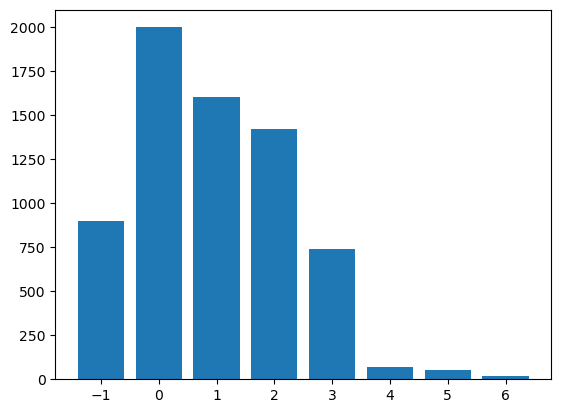

In [15]:
# How many different users per label:
plt.bar(range(-1,7),np.array(df_f.groupby("label_global")['User'].nunique())) ; plt.show() 

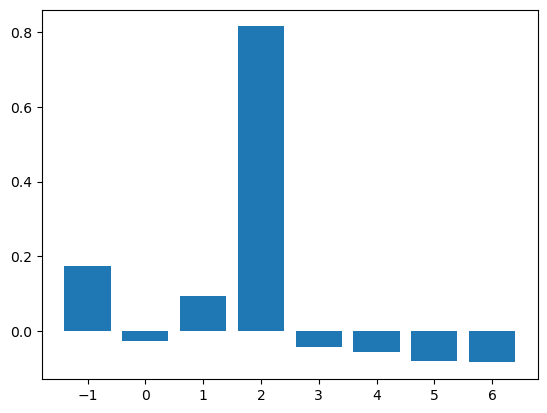

In [16]:
# Average transaction amount of each label:
plt.bar(range(-1,7),np.array(df_f.groupby("label_global").mean()['Amount'])) ; plt.show() 

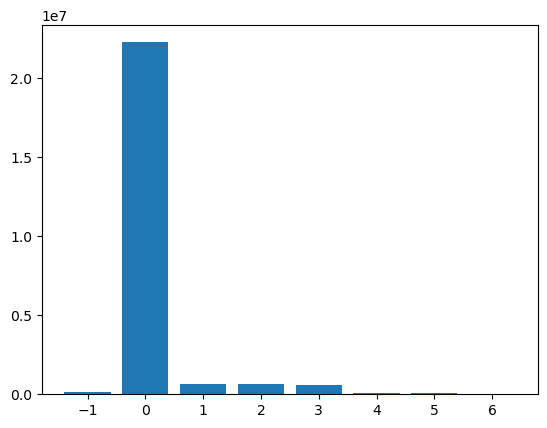

In [18]:
# How many transactions per label:
plt.bar(range(-1,7),np.array(df_f.groupby("label_global").size())) ; plt.show() 


In [38]:
# Export the parquet:
df.to_parquet('/home/onyxia/Projet-Statapp/df.parquet')